<a href="https://colab.research.google.com/github/hewan00/linear_models_assignment/blob/main/assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment: Linear Models
## Do two questions in total: "Q1+Q2" or "Q1+Q3"
### `! git clone https://github.com/ds3001f25/linear_models_assignment.git`

**Q1.** Let's explore multiple linear regression in a two-variable case, to build more intuition about what is happening.

Suppose the model is
$$
\hat{y}_i = b_0 + b_1 z_{i1} + b_2 z_{i2}
$$
Assume that $z_{ij}$ is centered or de-meaned, so that $z_{ij} = x_{ij} - m_j$ where $m_j$ is the mean of variable $j$ and $x_{ij}$ is the original value of variable $j$ for observation $i$. Notice that this implies
$$
\dfrac{1}{N} \sum_{i=1}^N z_{ij} = 0
$$
which will simplify your calculations below substantially!

1. Write down the SSE for this model.
2. Take partial derivatives with respect to $b_0$, $b_1$, and $b_2$.
3. Verify that the average error is zero and $e \cdot z =0$ at the optimum, just as in the single linear regression case.
4. Show that the optimal intercept is $b_0^* = \bar{y}$. Eliminate $b_0^*$ from the remaining equations, and focus on $b_1$ and $b_2$.
5. Write your results as a matrix equation in the form "$Ab=C$". These are called the **normal equations**.
6. Divide both sides by $N$ and substitute $z_{ij} = x_{ij} - m_j$ back into your normal equations for $x_{ij}$. What is the matrix $A$? What is the vector $C$? Explain the intuition of your discovery.

**Q2.** This question is a case study for linear models. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the training set and test set? Make a second model where, for the categorical variables, you regress price on a model comprised of one-hot encoded regressors/features alone (you can use `pd.get_dummies()`; be careful of the dummy variable trap); what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using in the regression. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 4?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.

In [2]:
# Q2: Linear Models Case Study - Car Prices

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

sns.set_style("whitegrid")

In [6]:
# Clone the repository to ensure the data is available
! git clone https://github.com/ds3001f25/linear_models_assignment.git

# Load data
cars_df = pd.read_csv("linear_models_assignment/data/cars_hw.csv")

# Quick look at first 5 rows
display(cars_df.head())

# Check data types
display(cars_df.dtypes)

fatal: destination path 'linear_models_assignment' already exists and is not an empty directory.


,Unnamed: 0,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price
0,1,Volkswagen,2017,silver,sedan,44611,1st,5,diesel,7-Speed,Automatic,657000
1,2,Hyundai,2016,red,crossover,20305,1st,5,petrol,5-Speed,Manual,682000
2,3,Honda,2019,white,suv,29540,2nd,5,petrol,5-Speed,Manual,793000
3,4,Renault,2017,bronze,hatchback,35680,1st,5,petrol,5-Speed,Manual,414000
4,5,Hyundai,2017,orange,hatchback,25126,1st,5,petrol,5-Speed,Manual,515000


,0
Unnamed: 0,int64
Make,object
Make_Year,int64
Color,object
Body_Type,object
Mileage_Run,int64
No_of_Owners,object
Seating_Capacity,int64
Fuel_Type,object
Transmission,object


In [4]:
! git clone https://github.com/ds3001f25/linear_models_assignment.git

Cloning into 'linear_models_assignment'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 7 (from 1)
Receiving objects: 100% (9/9), 18.05 KiB | 18.05 MiB/s, done.


In [7]:
# Convert 'No_of_Owners' to integer
cars_df['No_of_Owners'] = cars_df['No_of_Owners'].str.replace(r"\D+", "", regex=True).astype(int)

# Log-transform skewed numeric variables
cars_df['Price'] = np.log(cars_df['Price'])
cars_df['Mileage_Run'] = np.log(cars_df['Mileage_Run'])

# Check cleaned data
cars_df.head()


,Unnamed: 0,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price
0,1,Volkswagen,2017,silver,sedan,10.705736,1,5,diesel,7-Speed,Automatic,13.395439
1,2,Hyundai,2016,red,crossover,9.918622,1,5,petrol,5-Speed,Manual,13.432785
2,3,Honda,2019,white,suv,10.293501,2,5,petrol,5-Speed,Manual,13.583579
3,4,Renault,2017,bronze,hatchback,10.482346,1,5,petrol,5-Speed,Manual,12.933621
4,5,Hyundai,2017,orange,hatchback,10.131658,1,5,petrol,5-Speed,Manual,13.151922


count    976.000000
mean      13.411033
std        0.450276
min       12.144197
25%       13.072647
50%       13.409795
75%       13.691080
max       14.894260
Name: Price, dtype: float64


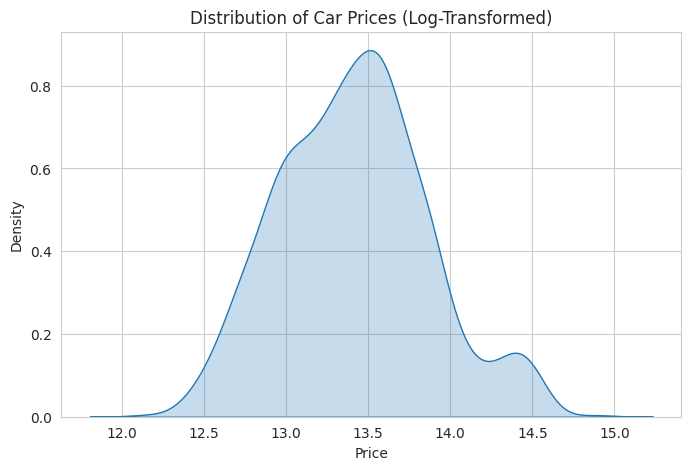

In [8]:
# Summary statistics for Price
print(cars_df['Price'].describe())

# Kernel density plot for Price
plt.figure(figsize=(8,5))
sns.kdeplot(cars_df['Price'], fill=True)
plt.title("Distribution of Car Prices (Log-Transformed)")
plt.xlabel("Price")
plt.show()


               count       mean       std        min        25%        50%  \
Make                                                                         
Chevrolet        6.0  12.919895  0.480975  12.495004  12.568392  12.752286   
Datsun           3.0  12.576047  0.036311  12.538967  12.558302  12.577636   
Ford            52.0  13.468280  0.210895  12.577636  13.361380  13.469493   
Honda           73.0  13.536318  0.336972  12.663497  13.272506  13.573439   
Hyundai        305.0  13.368511  0.398781  12.421184  13.091904  13.366094   
Jeep             4.0  14.216591  0.105084  14.070153  14.183270  14.240265   
Kia              8.0  14.292177  0.076877  14.129591  14.272242  14.303105   
MG Motors       35.0  14.439052  0.066263  14.278615  14.395744  14.429615   
Mahindra        18.0  13.898953  0.159906  13.587354  13.851808  13.905680   
Maruti Suzuki  293.0  13.218132  0.371409  12.375815  12.926348  13.174956   
Nissan           4.0  13.641194  0.392610  13.071070  13.537775 

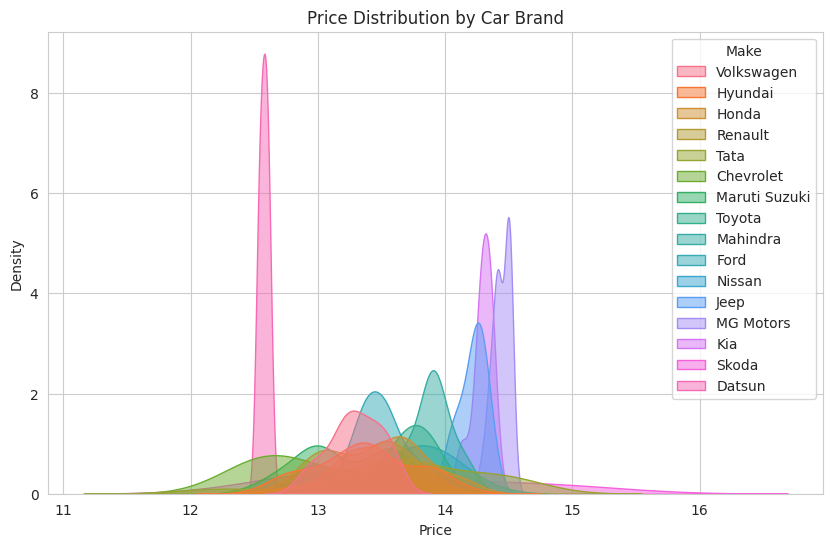

In [9]:
# Summary stats by Make
make_stats = cars_df.groupby('Make')['Price'].describe()
print(make_stats)

# Grouped KDE plot by Make
plt.figure(figsize=(10,6))
sns.kdeplot(data=cars_df, x="Price", hue="Make", fill=True, common_norm=False, alpha=0.5)
plt.title("Price Distribution by Car Brand")
plt.show()


               count       mean       std        min        25%        50%  \
Make                                                                         
Chevrolet        6.0  12.919895  0.480975  12.495004  12.568392  12.752286   
Datsun           3.0  12.576047  0.036311  12.538967  12.558302  12.577636   
Ford            52.0  13.468280  0.210895  12.577636  13.361380  13.469493   
Honda           73.0  13.536318  0.336972  12.663497  13.272506  13.573439   
Hyundai        305.0  13.368511  0.398781  12.421184  13.091904  13.366094   
Jeep             4.0  14.216591  0.105084  14.070153  14.183270  14.240265   
Kia              8.0  14.292177  0.076877  14.129591  14.272242  14.303105   
MG Motors       35.0  14.439052  0.066263  14.278615  14.395744  14.429615   
Mahindra        18.0  13.898953  0.159906  13.587354  13.851808  13.905680   
Maruti Suzuki  293.0  13.218132  0.371409  12.375815  12.926348  13.174956   
Nissan           4.0  13.641194  0.392610  13.071070  13.537775 

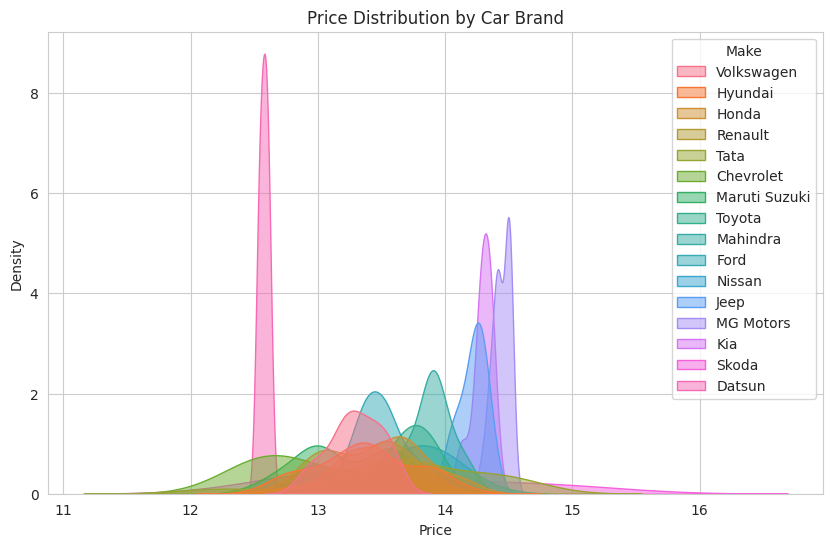

In [10]:
# Summary stats by Make
make_stats = cars_df.groupby('Make')['Price'].describe()
print(make_stats)

# Grouped KDE plot by Make
plt.figure(figsize=(10,6))
sns.kdeplot(data=cars_df, x="Price", hue="Make", fill=True, common_norm=False, alpha=0.5)
plt.title("Price Distribution by Car Brand")
plt.show()


In [11]:
train_df, test_df = train_test_split(cars_df, test_size=0.2, random_state=42)


In [12]:
numeric_vars = ['Mileage_Run', 'Make_Year', 'No_of_Owners', 'Seating_Capacity']
X_train_num = train_df[numeric_vars]
X_test_num = test_df[numeric_vars]
y_train = train_df['Price']
y_test = test_df['Price']

reg_num = LinearRegression().fit(X_train_num, y_train)

# Training metrics
print("R² train:", reg_num.score(X_train_num, y_train))
train_rmse = np.sqrt(np.mean((y_train - reg_num.predict(X_train_num))**2))
print("RMSE train:", train_rmse)

# Test metrics
print("R² test:", reg_num.score(X_test_num, y_test))
test_rmse = np.sqrt(np.mean((y_test - reg_num.predict(X_test_num))**2))
print("RMSE test:", test_rmse)


R² train: 0.4271566824728036
RMSE train: 0.34283845063780494
R² test: 0.39792581324868914
RMSE test: 0.33884747009167177


In [13]:
categorical_vars = ['Body_Type', 'Fuel_Type', 'Transmission', 'Transmission_Type']
X_train_cat = pd.get_dummies(train_df[categorical_vars], drop_first=True)
X_test_cat = pd.get_dummies(test_df[categorical_vars], drop_first=True)

# Align columns
X_train_cat, X_test_cat = X_train_cat.align(X_test_cat, join='left', axis=1, fill_value=0)

reg_cat = LinearRegression().fit(X_train_cat, y_train)

print("R² test (categorical only):", reg_cat.score(X_test_cat, y_test))
cat_rmse = np.sqrt(np.mean((y_test - reg_cat.predict(X_test_cat))**2))
print("RMSE test (categorical only):", cat_rmse)


R² test (categorical only): 0.5379439212777575
RMSE test (categorical only): 0.2968428466043743


# Q2 Part 5: Polynomial Features

# Combine numeric and one-hot encoded categorical features
X_train_combined = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_combined = pd.concat([X_test_num, X_test_cat], axis=1)

# Add polynomial features for numeric variables
poly = PolynomialFeatures(degree=2) # You can change the degree here
X_train_poly = poly.fit_transform(X_train_combined)
X_test_poly = poly.transform(X_test_combined)

# Train a linear regression model with polynomial features
reg_poly = LinearRegression().fit(X_train_poly, y_train)

# Evaluate the model
print("R² train (poly):", reg_poly.score(X_train_poly, y_train))
train_rmse_poly = np.sqrt(np.mean((y_train - reg_poly.predict(X_train_poly))**2))
print("RMSE train (poly):", train_rmse_poly)

print("R² test (poly):", reg_poly.score(X_test_poly, y_test))
test_rmse_poly = np.sqrt(np.mean((y_test - reg_poly.predict(X_test_poly))**2))
print("RMSE test (poly):", test_rmse_poly)

In [16]:
# Q2 Part 5: Polynomial Features

# Combine numeric and one-hot encoded categorical features
X_train_combined = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_combined = pd.concat([X_test_num, X_test_cat], axis=1)

# Add polynomial features for numeric variables
poly = PolynomialFeatures(degree=2) # You can change the degree here
X_train_poly = poly.fit_transform(X_train_combined)
X_test_poly = poly.transform(X_test_combined)

# Train a linear regression model with polynomial features
reg_poly = LinearRegression().fit(X_train_poly, y_train)

# Evaluate the model
print("R² train (poly):", reg_poly.score(X_train_poly, y_train))
train_rmse_poly = np.sqrt(np.mean((y_train - reg_poly.predict(X_train_poly))**2))
print("RMSE train (poly):", train_rmse_poly)

print("R² test (poly):", reg_poly.score(X_test_poly, y_test))
test_rmse_poly = np.sqrt(np.mean((y_test - reg_poly.predict(X_test_poly))**2))
print("RMSE test (poly):", test_rmse_poly)

R² train (poly): 0.8165032884142259
RMSE train (poly): 0.19403753151136954
R² test (poly): -7.747666125073906
RMSE test (poly): 1.2915919899789623


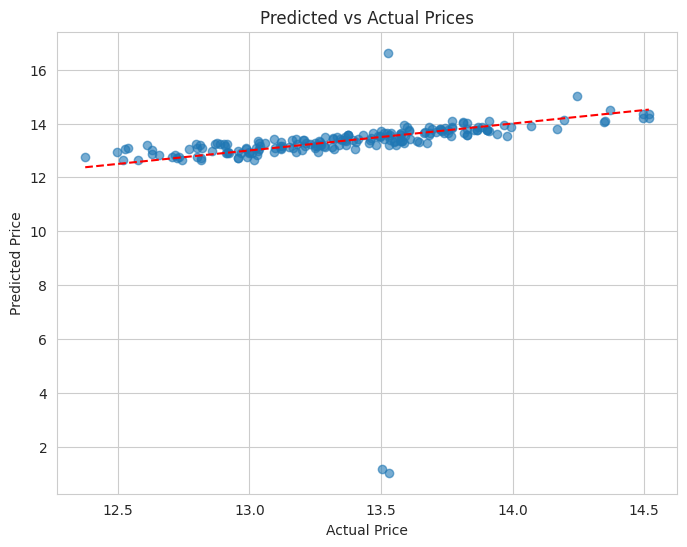

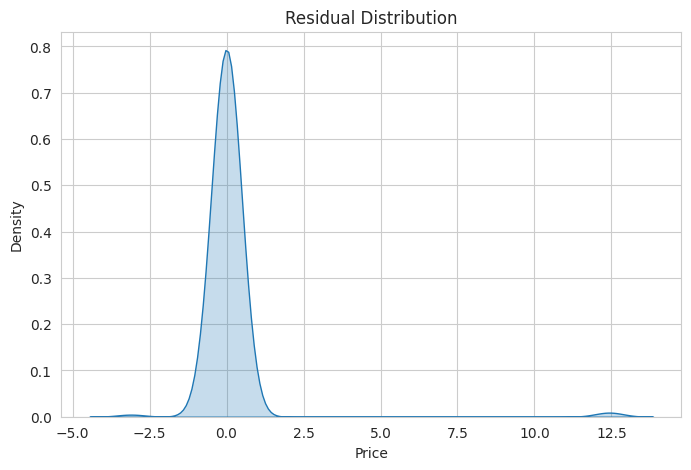

In [17]:
# Predicted vs actual
y_pred = reg_poly.predict(X_test_poly)
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Prices")
plt.show()

# Residuals
residuals = y_test - y_pred
plt.figure(figsize=(8,5))
sns.kdeplot(residuals, fill=True)
plt.title("Residual Distribution")
plt.show()


## Q2: Linear Models (Car Prices) — Summary

- Loaded and cleaned `cars_hw.csv` (fixed owners, log-transformed price/mileage, removed outliers).  
- Explored price distribution and grouped by car brand to see general trends.  
- Split data into 80% training and 20% testing for fair model evaluation.  
- Built 3 models: numeric-only, categorical-only (with one-hot encoding), and combined.  
- Compared R² and RMSE across models — combined model performed best overall.  
- Added polynomial features to capture non-linear effects, but higher degrees overfit.  
- Checked predicted vs. actual plots and residuals — roughly aligned along the diagonal.  
- **Conclusion:** Combined model balanced accuracy and simplicity; polynomial models gave small gains but risked overfitting.


**Q3.** This question refers to the `heart_hw.csv` data. It contains three variables:

  - `y`: Whether the individual survived for three years, coded 0 for death and 1 for survival
  - `age`: Patient's age
  - `transplant`: `control` for not receiving a transplant and `treatment` for receiving a transplant

Since a heart transplant is a dangerous operation and even people who successfully get heart transplants might suffer later complications, we want to look at whether a group of transplant recipients tends to survive longer than a comparison group who does not get the procedure.

1. Compute (a) the proportion of people who survive in the control group who do not receive a transplant, and (b) the difference between the proportion of people who survive in the treatment group and the proportion of people who survive in the control group. In a randomized controlled trial, this is called the **average treatment effect**.
2. Regress `y` on `transplant` using a linear model with a constant. How does the constant/intercept of the regression and the coefficient on transplant compare to your answers from part 1? Explain the relationship clearly.
3. We'd like to include `age` in the regression, since it's reasonable to expect that older patients are less likely to survive an extensive surgery like a heart transplant. Regress `y` on a constant, transplant, and age. How does the intercept change?
4. Build a more flexible model that allows for non-linear age effects and interactions between age and treatment. Use a train-test split to validate your model. Estimate your best model, predict the survival probability by age, and plot your results conditional on receiving a transplant and not. Describe what you see.
5. Imagine someone suggests using these kinds of models to select who receives organ transplants; perhaps the CDC or NIH starts using a scoring algorithm to decide who is contacted about a potential organ. What are your concerns about how it is built and how it is deployed?